# Experiment - Compare BLS model performance with historical datasets using data partitioning and data aggregation.
* This is an experimental idea that aggregate data points on longer time span than just one minute will improve performance and stability for any models other than RNN, especially in Fscore. 
* It is based on the thinking: An anomaly should and can only be determined by the features acrossing a rather large time span. The features extracted from the messages within only one minute are not enough to determine if there is an anomaly in this minute of time.   
* In this experiment, Aggregation of some time spans from 1 to 60 will be tested and the according mesurements (accuracy and fscore) will be compared.  
* You can specify time span and select datasets one by one, or run many tests with different parameters as a batch (integrated run) to observe the trend at the last step.   
* The datasets, algorithm, and parameters used to experiment are tried to be as same as possible to those from the following paper for comparing how the performance improved:  
![TABLE VIII.png](<attachment:TABLE VIII.png>)
Machine learning techniques for classifying network anomalies and intrusions  
Z Li, ALG Rios, G Xu, L Trajković  
2019 IEEE international symposium on circuits and systems (ISCAS), 1-5


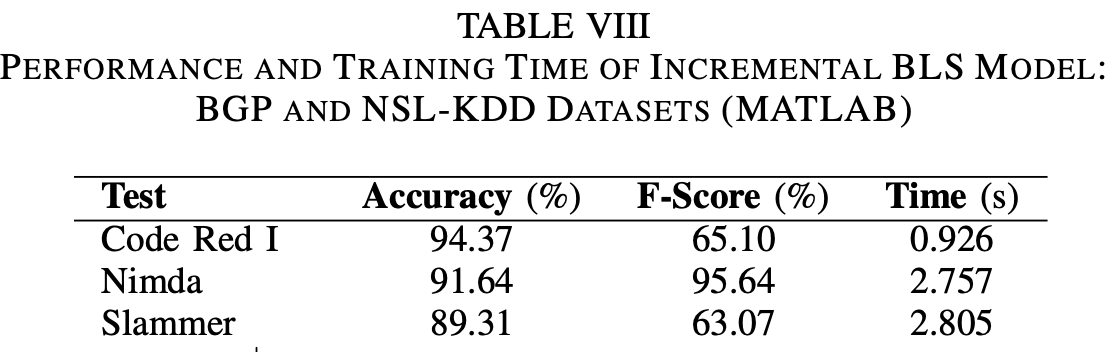

In [ ]:
# Switch between the following time spans to compare the results
time_span = 1
# time_span = 2
# time_span = 3
# time_span = 4
# time_span = 5
# time_span = 6
# time_span = 7
# time_span = 8
# time_span = 9
# time_span = 10
# time_span = 20
# time_span = 30
# time_span = 40
# time_span = 60


### Select dataset

In [ ]:
import numpy as np

# Load the datasets
path_app = "src"
dataset0 = np.loadtxt("./%s/data_historical/Code_Red_I.csv" % path_app, delimiter=",")
dataset1 = np.loadtxt("./%s/data_historical/Nimda.csv" % path_app, delimiter=",")
dataset2 = np.loadtxt("./%s/data_historical/Slammer.csv" % path_app, delimiter=",")
dataset3 = np.loadtxt("./%s/data_historical/Moscow_blackout.csv" % path_app, delimiter=",")
dataset4 = np.loadtxt("./%s/data_historical/WannaCrypt.csv" % path_app, delimiter=",")
dataset5 = np.loadtxt("./%s/data_historical/RIPE_regular.csv" % path_app, delimiter=",")
dataset6 = np.loadtxt("./%s/data_historical/BCNET_regular.csv" % path_app, delimiter=",")
datasets = {"Code_Red_I": dataset0, "Nimda": dataset1, "Slammer": dataset2, "Moscow_blackout": dataset3, "WannaCrypt": dataset4, "RIPE_regular": dataset5, "BCNET_regular": dataset6}

# Select datasets
data_name = "Slammer"
# data_name = "Nimda"
# data_name = "Code_Red_I"

# raw_train_datasets = [datasets[data_name]]
raw_test_dataset = datasets[data_name]

print("Raw test dataset shape: ", raw_test_dataset.shape)
print("Raw test labels of regular and anomaly: ", np.sum(raw_test_dataset[:,-1]==-1, axis=0), np.sum(raw_test_dataset[:,-1]==1, axis=0))
# print(raw_test_dataset[3206:3220, 4:16])
# print(raw_test_dataset[3206:3220, -1])

### Aggregate data points
According to the feature definition, apply different aggregation function to different column.
```
Columns 1-4: time (column 1: hour+minute; column 2: hour; column 3: minute; column 4: second)
Columns 5-41: features

List of features extracted from BGP update messages:
1. Number of announcements
2. Number of withdrawals
3. Number of announced NLRI prefixes
4. Number of withdrawn NLRI prefixes
5. Average AS-path length
6. Maximum AS-path length
7. Average unique AS-path length
8. Number of duplicate announcements
9. Number of implicit withdrawals
10. Number of duplicate withdrawals
11. Maximum edit distance
12. Arrival rate [Number]
13. Average edit distance
14-23. Maximum AS-path length = n, where n = (11, ...,20)
24-33. Maximum edit distance = n, where n = (7, ...,16)
34. Number of Interior Gateway Protocol (IGP) packets
35. Number of Exterior Gateway Protocol (EGP) packets
36. Number of incomplete packets
37: Packet size (B) [Average]
```
This list comes from src/CSharp_Tool_BGP/Readme.md

In [ ]:
import numpy as np

def aggregate_rows(arr, n):
    # Calculate the number of rows to keep to ensure the number of rows is a multiple of n
    rows_to_keep = (arr.shape[0] // n) * n
    arr = arr[:rows_to_keep]
    
    # Reshape the array to the shape (m/n, n, number of columns)
    reshaped = arr.reshape(-1, n, arr.shape[1])
    
    # Apply different aggregation functions to different columns
    coloumns_to_keep_the_first = [0, 1, 2, 3]
    # Set items with feature number.
    columns_to_sum = [1, 2, 3, 4, 8, 9, 10, 12, 34, 35, 36]
    columns_to_mean = [5, 7, 13, 37]
    columns_to_max = [6, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]  
    # Make it index of columns.
    columns_to_sum = [x+3 for x in columns_to_sum]
    columns_to_mean = [x+3 for x in columns_to_mean]
    columns_to_max = [x+3 for x in columns_to_max]
    
    aggregated = np.zeros((reshaped.shape[0], reshaped.shape[2]))
    aggregated[:, coloumns_to_keep_the_first] = reshaped[:, 0, coloumns_to_keep_the_first]  # Apply values of the first row in the group
    aggregated[:, columns_to_sum] = reshaped[:, :, columns_to_sum].sum(axis=1)
    aggregated[:, columns_to_mean] = reshaped[:, :, columns_to_mean].mean(axis=1)
    aggregated[:, columns_to_max] = reshaped[:, :, columns_to_max].max(axis=1)
    aggregated[:, 41] = np.round(np.sum(reshaped[:, :, 41] == 1, axis=1)/n)*2-1  # Apply mean and round to the label
    
    return aggregated

def aggregate_datasets(datasets, time_span):
    aggregated_datasets = []
    for dataset in datasets:
        aggregated_datasets.append(aggregate_rows(dataset, time_span))
    return aggregated_datasets

# train_datasets = aggregate_datasets(raw_train_datasets, time_span)
test_dataset = aggregate_rows(raw_test_dataset, time_span)

print("Aggregated test dataset shape: ", test_dataset.shape)
print("Aggregated test labels of regular and anomaly: ", np.sum(test_dataset[:,-1]==-1, axis=0), np.sum(test_dataset[:,-1]==1, axis=0))
# print(test_dataset[1603:1613, 4:16])
# print(test_dataset[1603:1613, -1])

### Partion single anomaly dataset
Use single anomaly dataset to generate both train and test datasets by partioning it with a specific portion such as 60% and 40%, respectively. The purpose for this kind of dataset preparation is for comparing result with the experiment results from previous papers of Prof. Zhida Li.   
Running this cell will replace the datasets prepared above.   

In [ ]:
# from src.data_partition import label_generator

def data_partition(dataset, cut_pct='64'):
    train_dataset = dataset
    test_dataset = dataset
    # Statistics of the dataset
    inds1 = np.where(dataset[:, 41] == 1);  # index of anomalies
    dataset_Stat = [dataset.shape[0], len(inds1[0]), 0, 0, 0];
    # print("The processing dataset has %d data points, with %d anomaly inside." % (dataset_Stat[0], dataset_Stat[1]))
    # Find the cutting point
    dataset_Stat[2] = round(dataset_Stat[1] * float(int(cut_pct[0]) / 10));  # np.round return float...percentage
    # print("Dataset %s/%s cut at index %d of the anomaly set."% (cut_pct[0], cut_pct[1], dataset_Stat[2]-1))  # dataset_Stat[2] cut point in anomaly
    # Cut
    anomaly_index = inds1[0]
    # print(anomaly_index)
    cut_index = anomaly_index[dataset_Stat[2] - 1]  # cut after cut_index, start from index 0, thats why -1
    # print("Cutting index will be included: ",cut_index)
    cut_index_fix = cut_index + 1
    train = dataset[0:cut_index_fix, :]  # +1 because the point cut_index should be counted
    test = dataset[cut_index_fix:, :]
    return train, test

dataset = test_dataset
train_dataset, test_dataset = data_partition(dataset)
print("Dataset %s has %d data points, with %d anomaly inside." % (data_name, dataset.shape[0], np.sum(dataset[:,-1]==1, axis=0)))
print("Training dataset shape: ", train_dataset.shape)
print("Training labels of regular and anomaly: ", np.sum(train_dataset[:,-1]==-1, axis=0), np.sum(train_dataset[:,-1]==1, axis=0))
print("Test dataset shape: ", test_dataset.shape)
print("Test labels of regular and anomaly: ", np.sum(test_dataset[:,-1]==-1, axis=0), np.sum(test_dataset[:,-1]==1, axis=0))


### Select features
Select some features instead of using all 37 features to observe how the performance changes. Default is to select all of them.

In [ ]:
# Must keep the first 4 of time stamps and the last one of the label in this step.
def select_features(train_dataset, test_dataset):
    # features_to_keep=[0, 1, 2, 3, 41]
    features = [x for x in range(42)]

    train_dataset = train_dataset[:, features]
    test_dataset = test_dataset[:, features]
    return train_dataset, test_dataset

train_dataset, test_dataset = select_features(train_dataset, test_dataset)
print("Training dataset shape: ", train_dataset.shape)
print("Test dataset shape: ", test_dataset.shape)

### Data normalization

In [ ]:
import sys
sys.path.append('./src/VFBLS_v110')
from scipy.stats import zscore
from bls.processing.replaceNan import replaceNan

def normalize(dataset, div = 1 ):
    row_index_end = dataset.shape[0] - dataset.shape[0] % div  # divisible by div, but What is div for?
    data_x = dataset[:row_index_end, 4:-1]
    data_x = zscore(data_x, axis=0, ddof=1)  # For each feature, mean = 0 and std = 1
    replaceNan(data_x)  # Replace "nan" with 0
    data_y = dataset[:row_index_end, -1]
    # Change training labels
    inds1 = np.where(data_y == -1)
    data_y[inds1] = 2
    return data_x,data_y

train_x, train_y = normalize(train_dataset)
test_x, test_y = normalize(test_dataset)

print("Training dataset shape: ", train_x.shape)
print("Training labels of regular and anomaly: ", np.sum(train_y==2), np.sum(train_y==1))
print("Test dataset shape: ", test_x.shape)
print("Test labels of regular and anomaly: ", np.sum(test_y==2), np.sum(test_y==1))


### Select top features

In [ ]:
from bls.processing.feature_select_imp_cnl import feature_select_imp_cnl

def top_features(train_x, train_y):
    # num_features = 5
    # features, _ = feature_select_imp_cnl(train_x, train_y, num_features)
    features = [x for x in range(train_x.shape[1])] # Defaut to use all features    
    return features

top = top_features(train_x, train_y)
train_x = train_x[:, top]
test_x = test_x[:, top]
print("Features: ", top)
print("Training dataset shape: ", train_x.shape)
print("Test dataset shape: ", test_x.shape)


### Training and testing

In [ ]:
from src.VFBLS_v110.bls.processing.one_hot_m import one_hot_m
from src.VFBLS_v110.bls.model.bls_train import bls_train_realtime

print("======================= BLS =======================\n")
def train_test(train_x, train_y, test_x, parameters=None):
    # Set parameters
    mem = 'low'
    # mem = 'high'
    # BLS parameters
    seed = 1  # set the seed for generating random numbers
    num_class = 2  # number of the classes
    epochs = 1  # number of epochs
    C = 2 ** -15  # parameter for sparse regularization
    s = 0.6  # the shrinkage parameter for enhancement nodes
    train_y = one_hot_m(train_y, num_class)
    # test_y = one_hot_m(test_y, num_class);
    #######################
    # N1* - the number of mapped feature nodes
    # N2* - the groups of mapped features
    # N3* - the number of enhancement nodes
    if mem == 'low':
        N1_bls = 20
        N2_bls = 5
        N3_bls = 100
    else:
        N1_bls = 200
        N2_bls = 10
        N3_bls = 100
    if parameters is not None:
        N1_bls = parameters["N1"]
        N2_bls = parameters["N2"]
        N3_bls = parameters["N3"]
    #######################

    train_err = np.zeros((1, epochs))
    train_time = np.zeros((1, epochs))
    test_time = np.zeros((1, epochs))
    np.random.seed(seed)  # set the seed for generating random numbers
    for j in range(0, epochs):
        trainingAccuracy, trainingTime, testingTime, predicted = \
        bls_train_realtime(train_x, train_y, test_x,
                            s, C,
                            N1_bls, N2_bls, N3_bls)

        train_err[0, j] = trainingAccuracy * 100
        train_time[0, j] = trainingTime
        test_time[0, j] = testingTime
    # predicted = [[1.], [2.], [2.], [2.], [2.]]
    predicted_list = []
    for label in predicted:
        predicted_list.append(label[0])
    return predicted_list

parameter_set = {"Code_Red_I": {"N1": 100, "N2": 1, "N3": 500}, 
                 "Nimda": {"N1": 500, "N2": 1, "N3": 700}, 
                 "Slammer": {"N1": 100, "N2": 25, "N3": 300}
                 }

predicted_list = train_test(train_x, train_y, test_x, parameter_set[data_name])

print("predicted_list:", predicted_list)


### 6. Accuracy and Fscore

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y, predicted_list)
fscore = f1_score(test_y, predicted_list)

print(f"Accuracy: {accuracy:.2%}, Fscore: {fscore:.2%}")

### 7. Integrated run


#### 7.1 Run with batch parameters

In [ ]:
import os

def blockPrint():
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    return old_stdout
def enablePrint(old_stdout):
    sys.stdout = old_stdout

time_span_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60]
# all_datasets = ["Code_Red_I", "Nimda", "Slammer", "Moscow_blackout", "WannaCrypt"]
data_names = ["Code_Red_I", "Nimda", "Slammer"]
results = []
for data_name in data_names:
    print(f"Data name: {data_name}")
    for time_span in time_span_list:
        dataset = aggregate_rows(datasets[data_name], time_span)
        train_dataset, test_dataset = data_partition(dataset)
        train_dataset, test_dataset = select_features(train_dataset, test_dataset)
        train_x, train_y = normalize(train_dataset)
        test_x, test_y = normalize(test_dataset)
        old_stdout = blockPrint()
        top = top_features(train_x, train_y)
        train_x = train_x[:, top]
        test_x = test_x[:, top]
        predicted_list = train_test(train_x, train_y, test_x, parameter_set[data_name])
        enablePrint(old_stdout)
        accuracy = accuracy_score(test_y, predicted_list)
        fscore = f1_score(test_y, predicted_list)
        row = [data_name, data_name, f"{time_span}", f"{accuracy*100:.2f}", f"{fscore*100:.2f}"]
        results.append(row)
        print(f"Time span: {time_span} - Accuracy: {accuracy:.2%}, Fscore: {fscore:.2%}")

# Save the results
file_name = "src/STAT/xpr_results.csv" 
# np.savetxt("xpr_results.csv", results, delimiter=",", fmt="%s,%s,%f,%f,%f")
results.insert(0, ["Train datasets", "Test datasets", "Time span", "Accuracy %", "Fscore %"])
results = np.array(results)
np.savetxt(file_name, results, delimiter=",", fmt="%s")
print("Results saved to", file_name)

#### 7.2 Plot the result

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot each series in a subplot
def subplot(label, series, ax, data_column):
    for series in series:
        mask = np.array([row[1] == series for row in results])
        x = results[mask, 2].astype(int)
        y = results[mask, data_column].astype(float)
        line = ax.plot(x, y, label=series)[0]
        
        # Add annotation for the point of baseline
        ax.annotate(f'{y[0]:.2f}', xy=(x[0], y[0]), xytext=(x[0] + 2, y[0]),
                    color=ax.lines[-1].get_color(), arrowprops=dict(arrowstyle='->'))
        
        # Find the index of the maximum value in y
        max_idx = np.argmax(y)
        max_x = x[max_idx]
        max_y = y[max_idx]
        
        # Draw a vertical line at the maximum value
        ax.axvline(x=max_x, color=ax.lines[-1].get_color(), linestyle='--')
        
        # Annotate the maximum value
        ax.annotate(f'{max_y:.2f}', xy=(max_x, max_y), xytext=(max_x + 1, max_y),
                    color=ax.lines[-1].get_color(), arrowprops=dict(arrowstyle='->'))
    
    ax.set_xlabel('Time Span')
    ax.set_ylabel(label)
    ax.set_xlim(left=1)
    ax.set_xticks(time_span_list)
    ax.legend()
    # fig.suptitle('Comparison of different time spans')

series = np.unique(results[1:, 1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
subplot('Accuracy', series, ax1, 3)
subplot('Fscore', series, ax2, 4)

plt.tight_layout()
plt.show()